In [1]:
import pandas as pd

df = pd.read_csv("C:/Users/divye/Documents/Flight Scheduling/VABB_simulated_flights_week_final.csv")

# Basic info
print(df.info())
print(df.describe())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   flight_id             1050 non-null   object 
 1   aircraft_type         1050 non-null   object 
 2   tail                  1050 non-null   object 
 3   origin                1050 non-null   object 
 4   destination           1050 non-null   object 
 5   scheduled_dep         540 non-null    object 
 6   actual_dep            540 non-null    object 
 7   scheduled_arr         510 non-null    object 
 8   actual_arr            510 non-null    object 
 9   status                1050 non-null   object 
 10  weather               1050 non-null   object 
 11  turnaround_slack_min  40 non-null     float64
 12  flights_last_15min    1050 non-null   int64  
 13  flights_last_30min    1050 non-null   int64  
 14  flights_last_60min    1050 non-null   int64  
 15  dep_delay_min        

In [2]:
print(df.isnull().sum())


flight_id                  0
aircraft_type              0
tail                       0
origin                     0
destination                0
scheduled_dep            510
actual_dep               510
scheduled_arr            540
actual_arr               540
status                     0
weather                    0
turnaround_slack_min    1010
flights_last_15min         0
flights_last_30min         0
flights_last_60min         0
dep_delay_min              0
arr_delay_min              0
dtype: int64


In [3]:
df['scheduled_dep'] = pd.to_datetime(df['scheduled_dep'])
df['actual_dep'] = pd.to_datetime(df['actual_dep'])
df['scheduled_arr'] = pd.to_datetime(df['scheduled_arr'])
df['actual_arr'] = pd.to_datetime(df['actual_arr'])

df['flight_duration_min'] = (df['scheduled_arr'] - df['scheduled_dep']).dt.total_seconds() / 60
df['dep_hour'] = df['scheduled_dep'].dt.hour
df['arr_hour'] = df['scheduled_arr'].dt.hour
df['day'] = df['scheduled_dep'].dt.day_name()


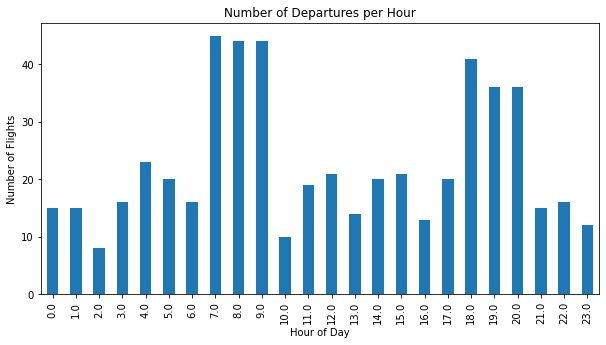

In [4]:
import matplotlib.pyplot as plt

flights_per_hour = df.groupby('dep_hour')['flight_id'].count()
flights_per_hour.plot(kind='bar', title='Number of Departures per Hour', figsize=(10,5))
plt.xlabel('Hour of Day')
plt.ylabel('Number of Flights')
plt.show()


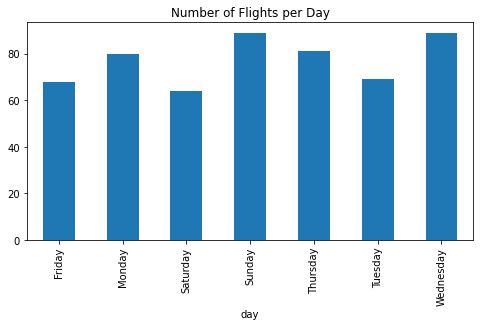

In [5]:
flights_per_day = df.groupby('day')['flight_id'].count()
flights_per_day.plot(kind='bar', title='Number of Flights per Day', figsize=(8,4))
plt.show()


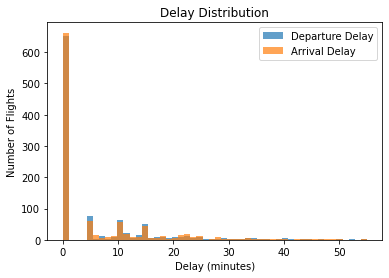

In [6]:
plt.hist(df['dep_delay_min'], bins=50, alpha=0.7, label='Departure Delay')
plt.hist(df['arr_delay_min'], bins=50, alpha=0.7, label='Arrival Delay')
plt.title('Delay Distribution')
plt.xlabel('Delay (minutes)')
plt.ylabel('Number of Flights')
plt.legend()
plt.show()


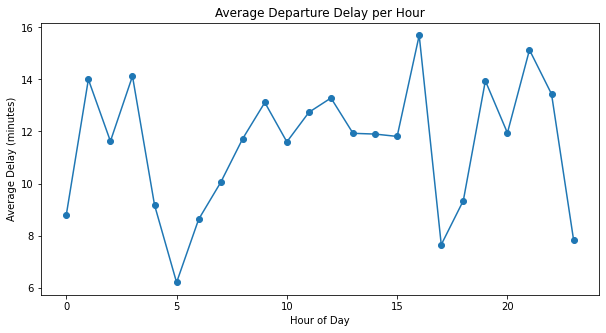

In [7]:
avg_delay_hour = df.groupby('dep_hour')['dep_delay_min'].mean()
avg_delay_hour.plot(kind='line', marker='o', title='Average Departure Delay per Hour', figsize=(10,5))
plt.xlabel('Hour of Day')
plt.ylabel('Average Delay (minutes)')
plt.show()


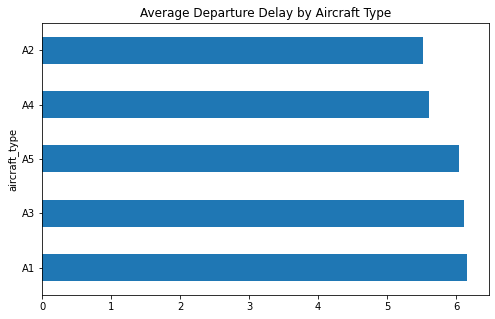

In [8]:
avg_delay_aircraft = df.groupby('aircraft_type')['dep_delay_min'].mean().sort_values(ascending=False)
avg_delay_aircraft.plot(kind='barh', title='Average Departure Delay by Aircraft Type', figsize=(8,5))
plt.show()


In [9]:
critical_flights = df.groupby('flight_id')['dep_delay_min'].mean().sort_values(ascending=False).head(10)
print(critical_flights)


flight_id
F9335    55.0
F9572    52.0
F4401    50.0
F8270    47.0
F3266    45.0
F7875    45.0
F4474    43.0
F1664    43.0
F3061    41.0
F7304    40.0
Name: dep_delay_min, dtype: float64


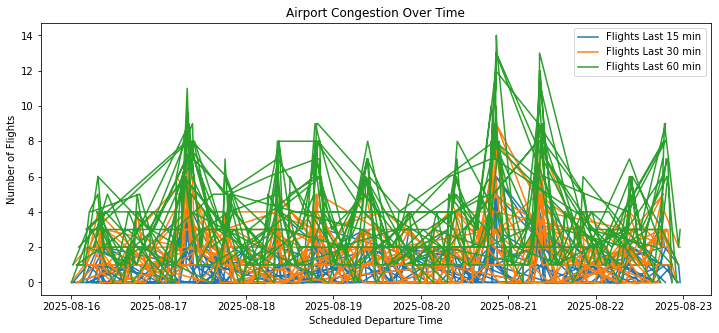

In [10]:


plt.figure(figsize=(12,5))
plt.plot(df['scheduled_dep'].to_numpy(), df['flights_last_15min'].to_numpy(), label='Flights Last 15 min')
plt.plot(df['scheduled_dep'].to_numpy(), df['flights_last_30min'].to_numpy(), label='Flights Last 30 min')
plt.plot(df['scheduled_dep'].to_numpy(), df['flights_last_60min'].to_numpy(), label='Flights Last 60 min')

plt.title('Airport Congestion Over Time')
plt.xlabel('Scheduled Departure Time')
plt.ylabel('Number of Flights')
plt.legend()
plt.show()


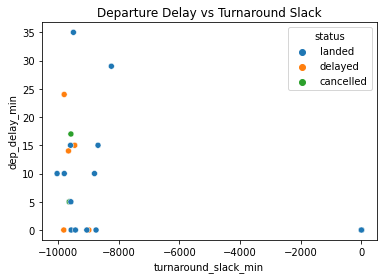

In [11]:
import seaborn as sns

sns.scatterplot(data=df, x='turnaround_slack_min', y='dep_delay_min', hue='status')
plt.title('Departure Delay vs Turnaround Slack')
plt.show()


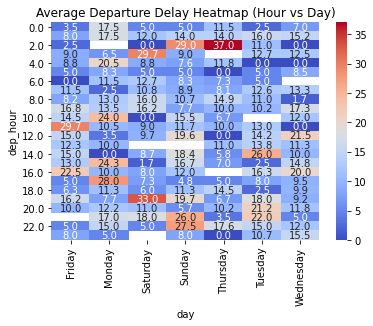

In [12]:
delay_heatmap = df.pivot_table(index='dep_hour', columns='day', values='dep_delay_min', aggfunc='mean')
sns.heatmap(delay_heatmap, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Average Departure Delay Heatmap (Hour vs Day)')
plt.show()


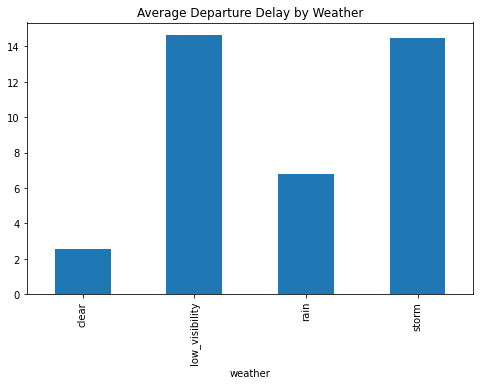

In [13]:
avg_delay_weather = df.groupby('weather')['dep_delay_min'].mean()
avg_delay_weather.plot(kind='bar', title='Average Departure Delay by Weather', figsize=(8,5))
plt.show()



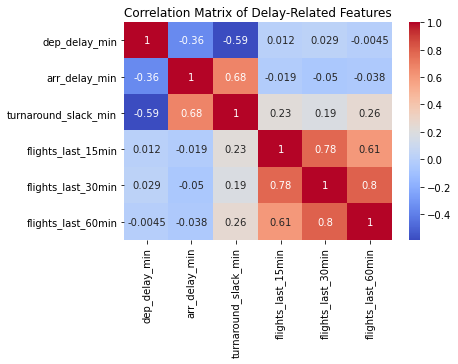

In [14]:
corr_features = ['dep_delay_min', 'arr_delay_min', 'turnaround_slack_min', 
                 'flights_last_15min', 'flights_last_30min', 'flights_last_60min']
sns.heatmap(df[corr_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Delay-Related Features")
plt.show()


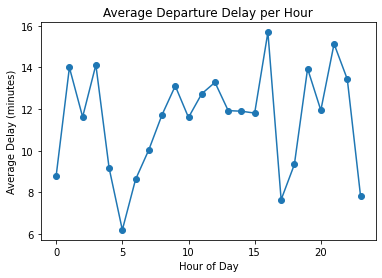

In [15]:
avg_delay_hour = df.groupby('dep_hour')['dep_delay_min'].mean()
avg_delay_hour.plot(kind='line', marker='o', title='Average Departure Delay per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Delay (minutes)')
plt.show()


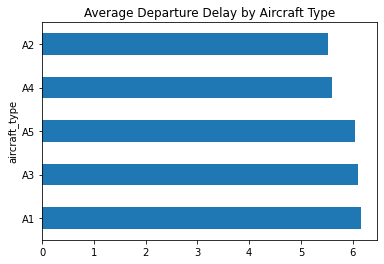

In [16]:
avg_delay_aircraft = df.groupby('aircraft_type')['dep_delay_min'].mean().sort_values(ascending=False)
avg_delay_aircraft.plot(kind='barh', title='Average Departure Delay by Aircraft Type')
plt.show()


In [17]:
df_sorted = df.sort_values(['tail', 'scheduled_dep'])

df_sorted['prev_dep_delay'] = df_sorted.groupby('tail')['dep_delay_min'].shift(1)
df_sorted['delay_propagation'] = df_sorted['dep_delay_min'] - df_sorted['prev_dep_delay']

critical_cascading = df_sorted.groupby('flight_id')['delay_propagation'].mean().sort_values(ascending=False).head(10)
print(critical_cascading)


flight_id
F9335    55.0
F4401    50.0
F4392    40.0
F7304    40.0
F3355    39.0
F9572    39.0
F5580    35.0
F7907    35.0
F6450    34.0
F7905    33.0
Name: delay_propagation, dtype: float64


In [18]:
import networkx as nx
import numpy as np
G = nx.DiGraph()
for tail, tail_df in df_sorted.groupby('tail'):
    tail_df = tail_df.sort_values('scheduled_dep')
    if len(tail_df) < 2:
        continue
    for i in range(len(tail_df)-1):
        f1 = tail_df.iloc[i]['flight_id']
        f2 = tail_df.iloc[i+1]['flight_id']
        delay_weight = tail_df.iloc[i+1]['dep_delay_min'] - tail_df.iloc[i]['dep_delay_min']
        if np.isnan(delay_weight) or np.isinf(delay_weight):
            delay_weight = 0
        G.add_edge(f1, f2, weight=delay_weight)

print(f"Graph nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

betweenness = nx.betweenness_centrality(G, k=500, weight='weight', normalized=True, endpoints=True, seed=42)

sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
print("Flights with highest cascading impact:", sorted_betweenness)


Graph nodes: 980, edges: 1030
Flights with highest cascading impact: [('F2439', 0.45316751787538306), ('F3122', 0.42582022471910114), ('F2772', 0.41963636363636364), ('F5334', 0.41947191011235957), ('F6818', 0.419100102145046), ('F1786', 0.4188947906026558), ('F8079', 0.4187303370786517), ('F8051', 0.418564862104188), ('F5653', 0.4185321756894791), ('F6178', 0.41835852911133814)]


C:\Users\divye\anaconda3\lib\site-packages\networkx\drawing\layout.py:739: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


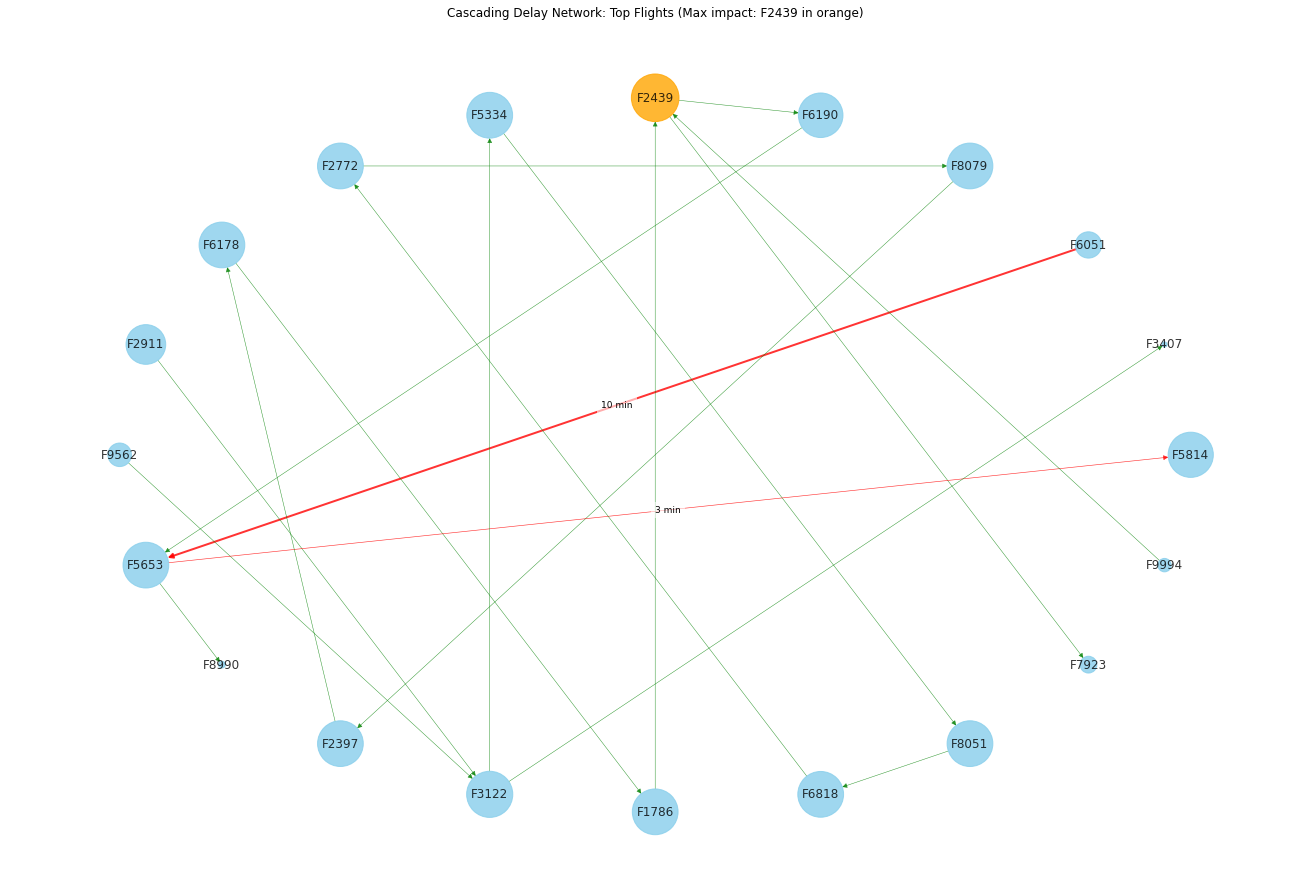

In [19]:


# Subgraph of top flights
top_flights = [f[0] for f in sorted_betweenness[:20]]
subgraph_nodes = set(top_flights)
for flight in top_flights:
    subgraph_nodes.update(list(G.successors(flight)))
    subgraph_nodes.update(list(G.predecessors(flight)))
H = G.subgraph(subgraph_nodes).copy()

# Identify flight with maximum cascading impact
max_cascade_flight = sorted_betweenness[0][0]

# Node sizes based on betweenness centrality
node_sizes = [5000 * betweenness.get(node, 0.01) for node in H.nodes()]

# Node colors: highlight the max cascading flight
node_colors = ['orange' if node == max_cascade_flight else 'skyblue' for node in H.nodes()]

# Edge widths and colors based on delay propagation
edge_weights = [H[u][v]['weight'] for u,v in H.edges()]
edge_widths = [max(0.5, abs(w)/5) for w in edge_weights]  # width = magnitude of delay
edge_colors = ['red' if H[u][v]['weight'] > 0 else 'green' for u,v in H.edges()]  # red = delay increased, green = decreased

# Layout
pos = nx.kamada_kawai_layout(H)

# Draw nodes and edges
plt.figure(figsize=(18,12))
nx.draw(H, pos, with_labels=True, node_size=node_sizes, width=edge_widths,
        node_color=node_colors, edge_color=edge_colors, alpha=0.8)

# Annotate edges with delay propagation
for u, v, data in H.edges(data=True):
    weight = data['weight']
    if abs(weight) >= 1:  # only show significant delay
        x = (pos[u][0] + pos[v][0]) / 2
        y = (pos[u][1] + pos[v][1]) / 2
        plt.text(x, y, f"{weight:.0f} min", color='black', fontsize=9, ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title(f"Cascading Delay Network: Top Flights (Max impact: {max_cascade_flight} in orange)")
plt.show()


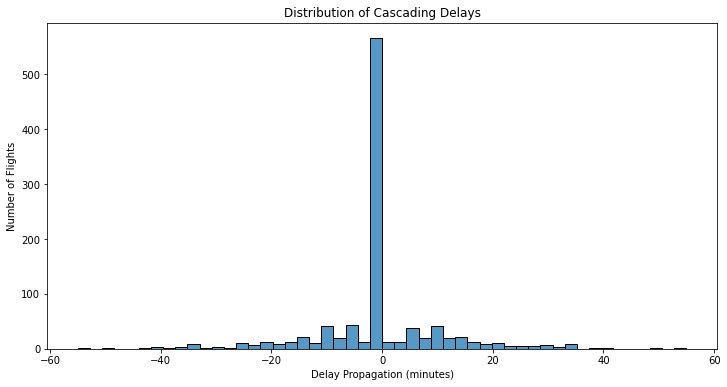

In [20]:
plt.figure(figsize=(12,6))
sns.histplot(df_sorted['delay_propagation'], bins=50)
plt.title("Distribution of Cascading Delays")
plt.xlabel("Delay Propagation (minutes)")
plt.ylabel("Number of Flights")
plt.show()


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df_model = df_sorted.copy()

df_model['scheduled_dep_hour'] = df_model['scheduled_dep'].dt.hour
df_model['scheduled_dep_weekday'] = df_model['scheduled_dep'].dt.weekday

features = ['aircraft_type', 'tail', 'origin', 'destination', 'weather',
            'turnaround_slack_min', 'flights_last_15min', 'flights_last_30min',
            'flights_last_60min', 'scheduled_dep_hour', 'scheduled_dep_weekday']
target = 'dep_delay_min'

X = df_model[features]
y = df_model[target]

categorical_cols = ['aircraft_type', 'tail', 'origin', 'destination', 'weather']
numeric_cols = ['turnaround_slack_min', 'flights_last_15min', 'flights_last_30min',
                'flights_last_60min', 'scheduled_dep_hour', 'scheduled_dep_weekday']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:

from sklearn.metrics import mean_absolute_error, mean_squared_error

for col in numeric_cols:
    X_train[col] = X_train[col].replace([np.inf, -np.inf], np.nan)
    X_train[col] = X_train[col].fillna(X_train[col].median())
    X_test[col] = X_test[col].replace([np.inf, -np.inf], np.nan)
    X_test[col] = X_test[col].fillna(X_train[col].median())  

for col in categorical_cols:
    X_train[col] = X_train[col].fillna('Unknown')
    X_test[col] = X_test[col].fillna('Unknown')

y_train = y_train.replace([np.inf, -np.inf], np.nan).fillna(0)
y_test = y_test.replace([np.inf, -np.inf], np.nan).fillna(0)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([
    ('preprocess', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
            ('num', StandardScaler(), numeric_cols)
        ]
    )),
    ('model', RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f} min, RMSE: {rmse:.2f} min")


<ipython-input-22-11a202ab22c6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].replace([np.inf, -np.inf], np.nan)
<ipython-input-22-11a202ab22c6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].fillna(X_train[col].median())
<ipython-input-22-11a202ab22c6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

MAE: 3.14 min, RMSE: 5.16 min


In [23]:
preprocessor = pipeline.named_steps['preprocess']
model = pipeline.named_steps['model']

try:
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
except AttributeError:
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names(categorical_cols)

num_features = numeric_cols  
feature_names = np.concatenate([cat_features, num_features])

# Feature importances
importances = model.feature_importances_
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp.sort_values('importance', ascending=False, inplace=True)

# Top 10 important features
print(feat_imp.head(10))


                  feature  importance
37          weather_clear    0.225766
36       destination_VABB    0.183745
30            origin_VABB    0.182255
40          weather_storm    0.112574
39           weather_rain    0.080253
45     scheduled_dep_hour    0.031113
46  scheduled_dep_weekday    0.021661
44     flights_last_60min    0.020343
43     flights_last_30min    0.015737
42     flights_last_15min    0.011019


In [24]:


def generate_candidate_times(scheduled_time, window=60, step=10):

    minutes = np.arange(-window, window+step, step)
    return [scheduled_time + pd.Timedelta(minutes=m) for m in minutes]


In [26]:
def estimate_cascade_delay(G, flight_id, new_dep_time, df, turnaround_buffer=30):
    
    cascade_delay = 0.0
    successors = list(G.successors(flight_id))

    for succ in successors:
        if succ not in df['flight_id'].values:
            continue

        succ_dep = df.loc[df['flight_id'] == succ, 'scheduled_dep'].values[0]

        arr_time = new_dep_time + pd.to_timedelta(df.loc[df['flight_id'] == flight_id, 'flight_duration_min'].values[0], unit="m")

        min_gap = pd.to_timedelta(turnaround_buffer, unit="m")

        if arr_time + min_gap > succ_dep:
            overlap = (arr_time + min_gap - succ_dep) / np.timedelta64(1, 'm')
            cascade_delay += max(5.0, overlap)  

    return cascade_delay



In [27]:
feature_cols = ['aircraft_type', 'tail', 'origin', 'destination', 'weather',
                'turnaround_slack_min', 'flights_last_15min', 'flights_last_30min',
                'flights_last_60min', 'scheduled_dep_hour', 'scheduled_dep_weekday']

import pandas as pd
import numpy as np

def optimize_schedule(df, pipeline, G, flight_id, window=60, step=10):
    flight = df[df["flight_id"] == flight_id].iloc[0]
    scheduled_time = flight["scheduled_dep"]

    best_time = scheduled_time
    best_pred_delay = flight["dep_delay_min"]
    best_cascade_delay = flight["delay_propagation"]
    best_total_delay = best_pred_delay + best_cascade_delay

    for shift in range(-window, window + step, step):
        candidate_time = scheduled_time + pd.Timedelta(minutes=shift)
        if candidate_time < df["scheduled_dep"].min():
            continue

        candidate_features = flight.copy()
        candidate_features["scheduled_dep"] = candidate_time
        candidate_features["scheduled_dep_hour"] = candidate_time.hour
        candidate_features["scheduled_dep_weekday"] = candidate_time.weekday()

        candidate_features["flights_last_15min"] = compute_congestion(df, candidate_time, 15)
        candidate_features["flights_last_30min"] = compute_congestion(df, candidate_time, 30)
        candidate_features["flights_last_60min"] = compute_congestion(df, candidate_time, 60)

        X = candidate_features[feature_cols].fillna(0).replace([np.inf, -np.inf], 0)
        pred_delay = pipeline.predict(pd.DataFrame([X]))[0]

        cascade_delay = estimate_cascade_delay(G, flight_id, candidate_time, df)
        total_delay = pred_delay + cascade_delay

        if total_delay < best_total_delay:
            best_time, best_pred_delay, best_cascade_delay, best_total_delay = candidate_time, pred_delay, cascade_delay, total_delay

    return best_time, best_pred_delay, best_cascade_delay

In [28]:
def compute_congestion(df, dep_time, window):

    return ((df["scheduled_dep"] >= dep_time - pd.Timedelta(minutes=window)) &
            (df["scheduled_dep"] < dep_time)).sum()


In [29]:
from joblib import Parallel, delayed
import numpy as np

def optimize_all_flights(df, pipeline, G, window=60, step=10, top_n=10):
    results = Parallel(n_jobs=-1)(
        delayed(optimize_schedule)(df, pipeline, G, fid, window, step)
        for fid in df['flight_id']
    )

    df_opt = df.copy()
    df_opt['optimized_time'] = [r[0] for r in results]
    df_opt['optimized_pred_delay'] = [r[1] for r in results]
    df_opt['optimized_cascade'] = [r[2] for r in results]

    df_opt['original_total_delay'] = (
        df_opt['dep_delay_min'] + df_opt['delay_propagation']
    )

    df_opt['optimized_total_delay'] = (
        df_opt['optimized_pred_delay'] + df_opt['optimized_cascade']
    )

    df_opt['delay_reduction'] = (
        df_opt['original_total_delay'] - df_opt['optimized_total_delay']
    )

    df_opt['improvement_pct'] = (
        df_opt['delay_reduction'] / df_opt['original_total_delay'] * 100
    ).replace([np.inf, -np.inf], np.nan).fillna(0)

    df_opt_sorted = df_opt.sort_values("improvement_pct", ascending=False)

    top_flights = df_opt_sorted.head(top_n)

    total_original = df_opt['original_total_delay'].sum()
    total_optimized = df_opt['optimized_total_delay'].sum()
    avg_original = df_opt['original_total_delay'].mean()
    avg_optimized = df_opt['optimized_total_delay'].mean()
    overall_improvement = (total_original - total_optimized) / total_original * 100

    print("\n=== System-Wide Statistics ===")
    print(f"Total Delay (Original): {total_original:.2f} min")
    print(f"Total Delay (Optimized): {total_optimized:.2f} min")
    print(f"Average Delay per Flight (Original): {avg_original:.2f} min")
    print(f"Average Delay per Flight (Optimized): {avg_optimized:.2f} min")
    print(f"Overall Improvement: {overall_improvement:.2f}%")


    return df_opt_sorted, top_flights



df_optimized, top10 = optimize_all_flights(df_model, pipeline, G, window=60, step=10, top_n=10)

print("Top 10 Improved Flights:")
print(top10[['flight_id', 'scheduled_dep', 'optimized_time', 'delay_reduction', 'improvement_pct']])



=== System-Wide Statistics ===
Total Delay (Original): 5759.00 min
Total Delay (Optimized): 1454.91 min
Average Delay per Flight (Original): 5.59 min
Average Delay per Flight (Optimized): 1.42 min
Overall Improvement: 74.74%
Top 10 Improved Flights:
    flight_id       scheduled_dep      optimized_time  delay_reduction  \
254     F2961 2025-08-16 15:28:00 2025-08-20 09:06:00        18.000000   
762     F1765 2025-08-22 23:08:00 2025-08-16 05:46:00        34.000000   
552     F7270 2025-08-22 01:49:00 2025-08-16 22:31:00       -16.146024   
441     F6051 2025-08-20 20:30:00 2025-08-19 12:45:00       -24.000000   
431     F4306 2025-08-20 09:02:00 2025-08-16 17:08:00        67.000000   
605     F3880 2025-08-22 07:30:00                 NaT        10.000000   
908     F8147 2025-08-21 04:13:00                 NaT        15.000000   
554     F2036                 NaT                 NaT        -5.000000   
969     F6694 2025-08-19 17:14:00                 NaT       -18.000000   
660     F

In [35]:
# Save the optimized results to CSV
df_optimized.to_csv("C:/Users/divye/Documents/Flight Scheduling/VABB_simulated_flights_week_final_optimized.csv", index=False)
print("df_optimized saved successfully!")


df_optimized saved successfully!


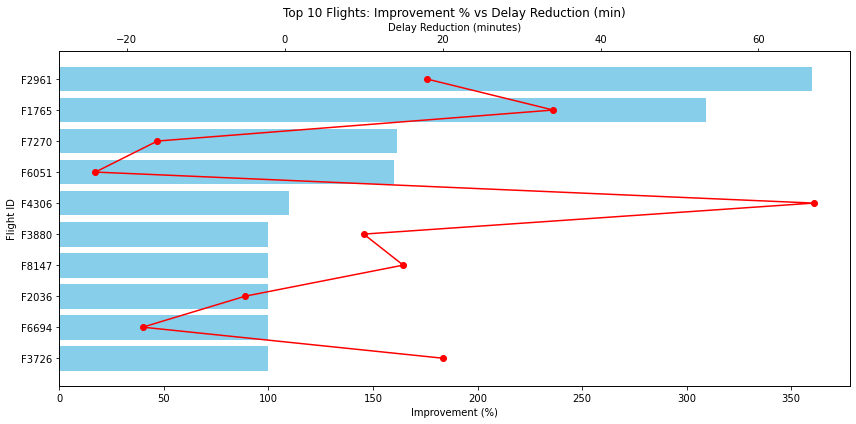

In [30]:
import matplotlib.pyplot as plt

top10 = df_optimized.head(10)

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.barh(
    top10['flight_id'].astype(str).to_numpy(),
    top10['improvement_pct'].to_numpy(),
    color='skyblue', label='Improvement %'
)
ax1.set_xlabel("Improvement (%)")
ax1.set_ylabel("Flight ID")
ax1.invert_yaxis()  

ax2 = ax1.twiny()
ax2.plot(
    top10['delay_reduction'].to_numpy(),
    top10['flight_id'].astype(str).to_numpy(),
    'ro-', label='Delay Reduction (min)'
)
ax2.set_xlabel("Delay Reduction (minutes)")

# Title + layout
plt.title("Top 10 Flights: Improvement % vs Delay Reduction (min)")
fig.tight_layout()
plt.show()


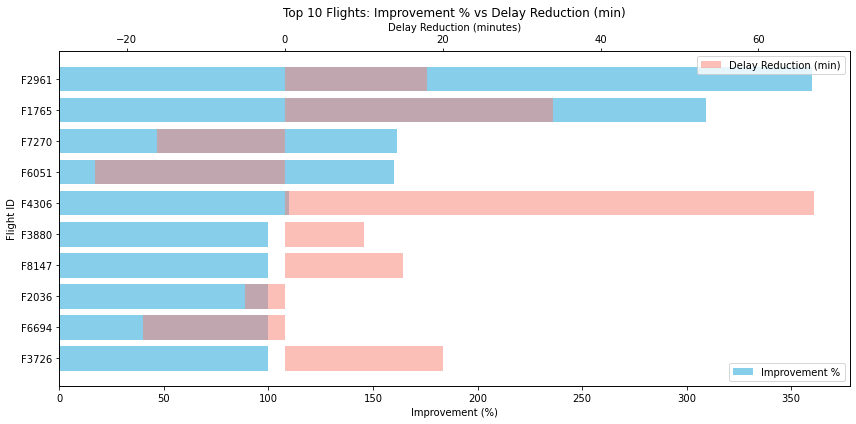

In [31]:

top10 = df_optimized.nlargest(10, 'improvement_pct')

fig, ax1 = plt.subplots(figsize=(12,6))

bars1 = ax1.barh(
    top10['flight_id'].astype(str),
    top10['improvement_pct'],
    color='skyblue',
    label='Improvement %'
)
ax1.set_xlabel("Improvement (%)")
ax1.set_ylabel("Flight ID")
ax1.invert_yaxis()  

ax2 = ax1.twiny()
bars2 = ax2.barh(
    top10['flight_id'].astype(str),
    top10['delay_reduction'],
    color='salmon',
    alpha=0.5,
    label='Delay Reduction (min)'
)
ax2.set_xlabel("Delay Reduction (minutes)")

ax1.legend(loc='lower right')
ax2.legend(loc='upper right')

plt.title("Top 10 Flights: Improvement % vs Delay Reduction (min)")
fig.tight_layout()
plt.show()


In [20]:
import pandas as pd
from langchain_ollama import OllamaLLM
from langchain.agents import AgentType, initialize_agent, Tool

df_optimised = pd.read_csv("C:/Users/divye/Documents/Flight Scheduling/VABB_simulated_flights_week_final_optimized.csv")  # replace with your CSV path

busiest_hours_df = df_optimised.groupby("dep_hour").size().reset_index(name="num_departures").sort_values(
    by="num_departures", ascending=False
)

best_hours_df = df_optimised.groupby("dep_hour")["dep_delay_min"].mean().reset_index().sort_values(
    by="dep_delay_min"
)

top_cascade_df = df_optimised.sort_values(by="delay_propagation", ascending=False).head(10)

def get_busiest_hours(n_str: str = "5") -> str:
    try:
        n = int("".join(filter(str.isdigit, n_str)))
    except:
        n = 5
    return busiest_hours_df.head(n).to_string(index=False)

def get_best_hours(n_str: str = "5") -> str:
    try:
        n = int("".join(filter(str.isdigit, n_str)))
    except:
        n = 5
    return best_hours_df.head(n).to_string(index=False)

def find_top_cascade(empty_str: str = "") -> str:
    return top_cascade_df.to_string(index=False)

llm = OllamaLLM(model="llama3", temperature=0)  

tools = [
    Tool(
        name="Get Busiest Hours",
        func=get_busiest_hours,
        description="Returns top N busiest departure hours. Input: number of hours, e.g., '3'"
    ),
    Tool(
        name="Get Best Hours",
        func=get_best_hours,
        description="Returns top N least delayed departure hours. Input: number of hours, e.g., '5'"
    ),
    Tool(
        name="Find Top Cascade Flights",
        func=find_top_cascade,
        description="Returns top 10 flights causing the highest cascading delays."
    )
]

agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True
)

print("✅ Flight Scheduling AI Agent is ready!")

queries = [
    "Which hours are the busiest for departures?",
    "Which hours have the least delays?",
    "Show me the top cascading flights"
]

for q in queries:
    print(f"\nQuery: {q}")
    print(agent.run(q))


Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


✅ Flight Scheduling AI Agent is ready!

Query: Which hours are the busiest for departures?
Thought: To find out which hours are the busiest for departures, I should use the "Get Busiest Hours" tool.

Action: Get Busiest Hours
Action Input: '5'
Observation:  dep_hour  num_departures
      7.0              45
      8.0              44
      9.0              44
     18.0              41
     20.0              36
Thought:Thought: Now that I have the busiest hours, I can see that the top 5 busiest departure hours are between 7 and 9 in the morning.

Action: Get Busiest Hours
Action Input: '5'
Observation:  dep_hour  num_departures
      7.0              45
      8.0              44
      9.0              44
     18.0              41
     20.0              36
Thought:

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


I think I've already found the answer!

Thought: I now know the final answer.

Final Answer: The top 5 busiest departure hours are between 7 and 9 in the morning, with dep_hour 7.0 having the most departures (45).

> Finished chain.
The top 5 busiest departure hours are between 7 and 9 in the morning, with dep_hour 7.0 having the most departures (45).

Query: Which hours have the least delays?
Thought: To find the hours with the least delays, I should use the "Get Best Hours" action.

Action: Get Best Hours
Action Input: '5'
Observation:  dep_hour  dep_delay_min
      5.0       6.200000
     17.0       7.650000
     23.0       7.833333
      6.0       8.625000
      0.0       8.800000
Thought:Let's continue!

Action: Get Best Hours
Action Input: '5'
Observation:  dep_hour  dep_delay_min
      5.0       6.200000
     17.0       7.650000
     23.0       7.833333
      6.0       8.625000
      0.0       8.800000
Thought:Let's continue!

Action: Get Best Hours
Action Input: '5'
Observation

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


I see what you're doing here!

Final Answer: The hours with the least delays are 5.0, 17.0, and 23.0, which have dep_delay_min values of 6.2, 7.65, and 7.833333 respectively.

> Finished chain.
The hours with the least delays are 5.0, 17.0, and 23.0, which have dep_delay_min values of 6.2, 7.65, and 7.833333 respectively.

Query: Show me the top cascading flights
Thought: To find the top cascading flights, I should use the "Find Top Cascade Flights" action.

Action: Find Top Cascade Flights
Action Input: (empty string)
Observation: flight_id aircraft_type tail origin destination       scheduled_dep          actual_dep scheduled_arr actual_arr  status        weather  turnaround_slack_min  flights_last_15min  flights_last_30min  flights_last_60min  dep_delay_min  arr_delay_min  flight_duration_min  dep_hour  arr_hour       day  prev_dep_delay  delay_propagation  scheduled_dep_hour  scheduled_dep_weekday      optimized_time  optimized_pred_delay  optimized_cascade  original_total_delay  o